# Setup and Data Loading

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Layer, Flatten

In [3]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# Make the directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [6]:
# for directory in os.listdir('archive\lfw-deepfunneled\lfw-deepfunneled'):
#     for file in os.listdir(os.path.join('archive\lfw-deepfunneled\lfw-deepfunneled', directory)):
#         EX_PATH = os.path.join('archive\lfw-deepfunneled\lfw-deepfunneled', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

In [4]:
# Import uuid library to generate unique image names
import uuid

In [5]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\c54c5a0c-111c-11ef-a099-b6b5b6e754a5.jpg'

In [6]:
# cap = cv2.VideoCapture(0)
# while cap.isOpened(): 
#     ret, frame = cap.read()
   
#     # Cut down frame to 250x250px
#     frame = frame[120:120+250,200:200+250, :]
    
#     # Collect anchors 
#     if cv2.waitKey(1) & 0XFF == ord('a'):
#         # Create the unique file path 
#         imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
#         # Write out anchor image
#         cv2.imwrite(imgname, frame)
    
#     # Collect positives
#     if cv2.waitKey(1) & 0XFF == ord('p'):
#         # Create the unique file path 
#         imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
#         # Write out positive image
#         cv2.imwrite(imgname, frame)
    
#     # Show image back to screen
#     cv2.imshow('Image Collection', frame)
    
#     # Breaking gracefully
#     if cv2.waitKey(1) & 0XFF == ord('q'):
#         break
        
# # Release the webcam
# cap.release()
# # Close the image show frame
# cv2.destroyAllWindows()

# Load and Preprocess Images

In [6]:
anchor = tf.data.Dataset.list_files('data/anchor/*.jpg').take(300)
positive = tf.data.Dataset.list_files('data/positive/*.jpg').take(300)
negative = tf.data.Dataset.list_files('data/negative/*.jpg').take(300)

In [7]:
anchor.as_numpy_iterator().next()  

b'data\\anchor\\3ee4f5fe-07bb-11ef-aca6-b4b5b6e754d6.jpg'

In [8]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0
    return img    

In [9]:
img = preprocess(anchor.as_numpy_iterator().next())

In [69]:
img

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.639951  , 0.64387256, 0.6634804 ],
        [0.5367647 , 0.5367647 , 0.5681372 ],
        [0.51960784, 0.51960784, 0.5509804 ],
        ...,
        [0.53088236, 0.51029414, 0.42352942],
        [0.6247549 , 0.5982843 , 0.49779412],
        [0.60294116, 0.56764704, 0.44411764]],

       [[0.56421566, 0.5681372 , 0.5838235 ],
        [0.51642156, 0.51960784, 0.54068625],
        [0.51715684, 0.5203431 , 0.5421569 ],
        ...,
        [0.51642156, 0.49313724, 0.41715688],
        [0.62990195, 0.6       , 0.5110294 ],
        [0.6125    , 0.5772059 , 0.45563725]],

       [[0.5139706 , 0.5178922 , 0.5276961 ],
        [0.51029414, 0.5142157 , 0.5301471 ],
        [0.50710785, 0.5110294 , 0.5276961 ],
        ...,
        [0.5242647 , 0.49485293, 0.4252451 ],
        [0.65612745, 0.6247549 , 0.5365196 ],
        [0.6237745 , 0.595098  , 0.47867647]],

       ...,

       [[0.627451  , 0.62352943, 0.64705884],
        [0.62

In [70]:
# Create labelled dataset:
# (anchor, positive) => 1
# (anchor, negative) => 0
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [9]:
data.as_numpy_iterator().next()

(b'data\\anchor\\4f031692-07bb-11ef-b68e-b4b5b6e754d6.jpg',
 b'data\\positive\\68a4d53b-07bb-11ef-94fd-b4b5b6e754d6.jpg',
 1.0)

In [12]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [13]:
result = preprocess_twin(*data.as_numpy_iterator().next()) # * will unpack the tuple into the function arguments

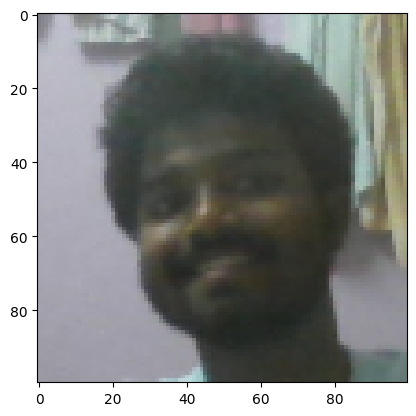

In [14]:
plt.imshow(result[0])

In [15]:
result[2]

1.0

In [16]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [17]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [18]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Building a Siamese Neural Network

## - Embedding Layer

In [19]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp) # (10,10) is the kernel size which is the size of the filter
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1) # it will reduce the size of the image by half
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=inp, outputs=d1, name='embedding')

In [20]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [24]:
l1 = L1Dist()

In [25]:
# Anchor image input in the network
input_image = Input(name='input_img', shape=(100,100,3))
input_image    

<KerasTensor shape=(None, 100, 100, 3), dtype=float32, sparse=None, name=input_img>

In [26]:
validation_image = Input(name='validation_img', shape=(100,100,3))
validation_image

<KerasTensor shape=(None, 100, 100, 3), dtype=float32, sparse=None, name=validation_img>

In [27]:
siamese_layer = L1Dist()
siamese_layer._name = 'distance'

In [28]:
input = embedding(input_image)
val = embedding(validation_image)

In [29]:
siamese_layer(input, val)

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_11>

In [30]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [31]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_3 (L1Dist)  │ (None, 4096)      │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# Training the Model

In [57]:
# Setup loss and optimizers
loss = tf.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(1e-4)

In [58]:
# Setup Checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=optimizer, siamese_model=siamese_model)

In [93]:
class FacialModel(Model):
    def __init__(self, siamese_model, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.siamese_model = siamese_model
    
    def compile(self, optimizer, loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.optimizer = optimizer
        self.loss = loss
    
    def train_step(self, batch):
        # Unpack the batch data
        input_image, validation_image, y = batch
        
        # Record all of our operations 
        with tf.GradientTape() as tape:     
            # Forward pass
            yhat = self.siamese_model([input_image, validation_image], training=True)
            # Calculate loss
            loss = self.loss(y, yhat)
            
        # Calculate gradients
        grad = tape.gradient(loss, self.siamese_model.trainable_variables)
        
        # Calculate updated weights and apply to siamese model
        self.optimizer.apply_gradients(zip(grad, self.siamese_model.trainable_variables))
            
        # Return loss
        return {"loss": loss}

    def call(self, X, **kwargs): 
        return self.siamese_model(X, **kwargs)


In [94]:
model = FacialModel(siamese_model)

In [95]:
model.compile(optimizer, loss)

In [96]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_3 (L1Dist)  │ (None, 4096)      │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
model.fit(train_data.take(1), epochs=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.2357


In [98]:
model.fit(train_data.take(1), epochs=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.1569


In [99]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [113]:
# Make predictions with reloaded model
preds = model.predict([test_input, test_val])
preds = (preds >= 0.5).astype(int)
preds.resize(y_true.shape)
preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])